In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm, metrics
import datetime as dt

import wfdb

## Read Data

(4201, 6)


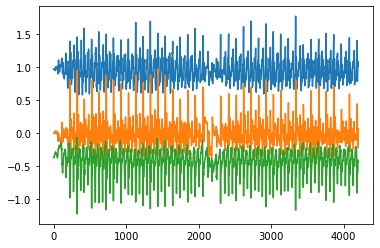

In [2]:
rawData = []
label = [];

for i in range(45):
    index = '{:03}'.format(i)
    fileName = 'LabWalks/co' + index + '_base'
    if os.path.isfile(fileName + '.hea'):
        record = wfdb.rdrecord(fileName)
        data = record.p_signal
        rawData.append(data)
        label.append(0)
    
    index = '{:03}'.format(i)
    fileName = 'LabWalks/fl' + index + '_base'
    if os.path.isfile(fileName + '.hea'):
        record = wfdb.rdrecord(fileName)
        data = record.p_signal
        rawData.append(data)
        label.append(1)

index = 3
print(np.shape(rawData[index]))
plt.plot(rawData[index][:,0:3])
a = gaussian_filter(rawData[index], sigma = 10)
#plt.plot(a)

## Check One Data

71
53.48837209302326
71
[0.19406699 0.23527438 0.23148333 0.23181188 0.24779442 0.25381453
 0.26673429 0.26423439 0.23460017 0.26567262 0.28233874 0.25879897
 0.24871448 0.30296762 0.26806135 0.26833307 0.26967971 0.28729628
 0.28064438 0.29171984 0.25389342 0.28395482 0.25905402 0.27576916
 0.25971177 0.29924622 0.26282876 0.29932166 0.26934893 0.25229761
 0.2406375  0.19500593 0.22343138 0.20499658 0.23604456 0.19963915
 0.17194875 0.25768179 0.25299848 0.27163637 0.2951304  0.32611002
 0.30423976 0.3026163  0.3016613  0.34077699 0.31474242 0.36194113
 0.3337536  0.34915359 0.3042505  0.28625405 0.30948961 0.31879155
 0.29115006 0.30491026 0.3027876  0.34384871 0.32550083 0.34324943
 0.33142705 0.31403249 0.30801016 0.28984156 0.29723702 0.2849721
 0.25272266 0.28682008 0.23971108 0.23322955 0.17753665]
(6, 71, 1000)


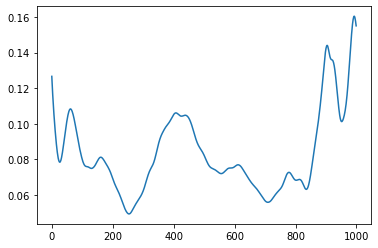

In [245]:
NumOfSamples = 1000

one = rawData[5]

accNorm = np.linalg.norm(one[:,0:3],axis=1)
gyrNorm = np.linalg.norm(one[:,3:],axis=1)
refData = gaussian_filter(accNorm, sigma = 10)
#check
checkData = []
checkTime = []
checkDataVar = []
#results
oneTime = []
oneIMUdata = [[] for i in range(6)]

index = 0
while index + 1 < len(one):
    startIndex = index
    #print(startIndex)
    while index + 1 < len(one) and refData[index] < max(refData[index-1], refData[index+1]):
        index = index + 1
    index = index + 1
    endIndex = index  
    #print(endIndex)
    if endIndex - startIndex > 20:
        checkTime.append(endIndex - startIndex)

    if endIndex < len(one) - 1 and endIndex - startIndex > 0.8*np.mean(checkTime) and endIndex - startIndex < 1.2*np.mean(checkTime):            
        usedData = accNorm[startIndex: endIndex]
        f = interp1d(range(len(usedData)), usedData, kind='cubic')
        x = np.linspace(0, len(usedData)-1, num=NumOfSamples, endpoint=False)
        processedData = f(x)
        checkDataVar.append(np.var(processedData))
        if(np.var(processedData) > 0.5 * np.mean(checkDataVar)):
            oneTime.append(endIndex - startIndex)
            checkData.append(processedData)
            for i in range(6):
                usedData = one[startIndex: endIndex, i]
                f = interp1d(range(len(usedData)), usedData, kind='cubic')
                x = np.linspace(0, len(usedData)-1, num=NumOfSamples, endpoint=False)
                oneIMUdata[i].append(f(x))    

checkData = np.array(checkData)
print(len(checkData))

    
checkData = np.array(checkData)
print(np.mean(checkTime))
print(len(checkData))
print(np.std(checkData, axis=1))

print(np.shape(np.array(oneIMUdata)))

plt.plot(np.std(np.array(checkData),axis=0)/np.mean(np.array(checkData),axis=0))
plt.show()

## Period Segmentation

In [ ]:
NumOfSamples = 1000

IMUdata = []
allTime = []

for one in rawData:

    accNorm = np.linalg.norm(one[:,0:3],axis=1)
    gyrNorm = np.linalg.norm(one[:,3:],axis=1)
    refData = gaussian_filter(accNorm, sigma = 10)
    #check
    checkData = []
    checkTime = []
    checkDataVar = []
    #results
    oneTime = []
    oneIMUdata = [[] for i in range(6)]
    
    index = 0
    while index + 1 < len(one):
        startIndex = index
        #print(startIndex)
        while index + 1 < len(one) and refData[index] < max(refData[index-1], refData[index+1]):
            index = index + 1
        index = index + 1
        endIndex = index  
        #print(endIndex)
        if endIndex - startIndex > 20:
            checkTime.append(endIndex - startIndex)

        if endIndex < len(one) - 1 and endIndex - startIndex > 0.8*np.mean(checkTime) and endIndex - startIndex < 1.2*np.mean(checkTime):            
            usedData = accNorm[startIndex: endIndex]
            f = interp1d(range(len(usedData)), usedData, kind='cubic')
            x = np.linspace(0, len(usedData)-1, num=NumOfSamples, endpoint=False)
            processedData = f(x)
            checkDataVar.append(np.var(processedData))
            if(np.var(processedData) > 0.2 * np.mean(checkDataVar)):
                oneTime.append(endIndex - startIndex)
                checkData.append(processedData)
                for i in range(6):
                    usedData = one[startIndex: endIndex, i]
                    f = interp1d(range(len(usedData)), usedData, kind='cubic')
                    x = np.linspace(0, len(usedData)-1, num=NumOfSamples, endpoint=False)
                    oneIMUdata[i].append(f(x))    
                
    IMUdata.append(oneIMUdata)
    allTime.append(oneTime)
    
print(len(IMUdata), len(allTime))

## Extract Feature

In [51]:
X = []
y = label

for i in range(len(IMUdata)):
    oneX = []
    #time related feature
    oneX.append(len(allTime[i]))
    oneX.append(np.mean(allTime[i]))
    oneX.append(np.std(allTime[i]))
    oneX.append(np.std(allTime[i])/(np.mean(allTime[i])))
    #acc related feature
    for j in range(6):
        data = IMUdata[i][j]
        oneX.append(np.mean(np.abs(np.mean(data, axis=0))))
        oneX.append(np.mean(np.std(data, axis=0)))
        oneX.append(np.mean(np.std(data, axis=0)/np.abs(np.mean(data, axis=0))))
    X.append(oneX)

scaler = StandardScaler()
Xs = scaler.fit_transform(X)
print(np.shape(np.array(X)))
print(np.mean(X, axis=0))

(73, 22)
[8.35753425e+01 5.40699209e+01 3.68963243e+00 6.77766473e-02
 9.89346198e-01 8.04601203e-02 8.12213338e-02 7.68159672e-02
 1.08051794e-01 1.16014067e+01 1.66790441e-01 6.66825512e-02
 2.46873740e+00 4.38824010e+00 1.94616681e+01 3.45755001e+01
 9.67400861e+00 9.84432851e+00 7.10625315e+00 3.57132295e+00
 1.31175068e+01 2.33237872e+01]


## Visualize Data

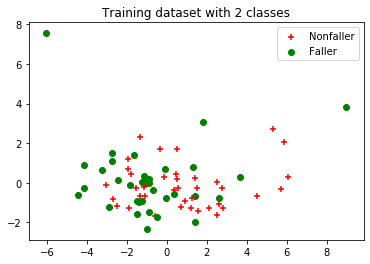

array([0.32022082, 0.09952827])

In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(Xs)
pca_2d = pca.transform(Xs)


import pylab as pl
for i in range(0, pca_2d.shape[0]):
    if y[i] == 0:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r',    marker='+')
    elif y[i] == 1:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g',    marker='o')

        
pl.legend([c1, c2], ['Nonfaller', 'Faller'])
pl.title('Training dataset with 2 classes')
pl.show()

pca.explained_variance_ratio_

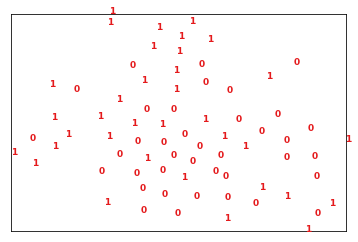

In [54]:
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)     
    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
        
from sklearn import manifold
#降维
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)

X_tsne = tsne.fit_transform(X)
#绘图
plot_embedding(X_tsne,y*5)
plt.show()

## Train and Test

In [115]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,random_state=42)

from sklearn.decomposition import PCA
pca = PCA(n_components=22).fit(X_train)
X_tf_pca = pca.transform(X_train)
X_tsf_pca = pca.transform(X_test)

X_tf_pca = X_train
X_tsf_pca = X_test

param_C = 2
param_gamma = 0.0001

classifier = svm.SVC(C=param_C,gamma=param_gamma,tol=0.001)
#classifier = svm.LinearSVC(C=param_C)

#We learn the digits on train part
start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))
classifier.fit(X_tf_pca, y_train)
end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

expected = y_test
predicted = classifier.predict(X_tsf_pca)
print(expected)
print(predicted)

cm = metrics.confusion_matrix(expected, predicted)
print("Confusion matrix:\n%s" % cm)

print("Accuracy={}".format(metrics.accuracy_score(expected, predicted)))

Start learning at 2019-11-15 11:56:48.036880
Stop learning 2019-11-15 11:56:48.038533
Elapsed learning 0:00:00.001653
[0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]
[0 0 1 0 1 0 1 0 0 1 1 0 1 1 0]
Confusion matrix:
[[6 2]
 [2 5]]
Accuracy=0.7333333333333333


In [299]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1,random_state=42)

from sklearn.model_selection import cross_val_score

param_C = 2
param_gamma = 0.0001

classifier = svm.SVC(C=param_C,gamma=param_gamma,tol=0.001)
scores = cross_val_score(classifier, X_train, y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#We learn the digits on train part

Accuracy: 0.69 (+/- 0.31)


In [323]:
recall = []
precision = []
f1 = []
for i in range(100):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.0001)

    from sklearn.model_selection import cross_validate

    scoring = ['precision', 'recall', 'f1']

    param_C = 1
    param_gamma = 0.0001

    classifier = svm.SVC(C=param_C,gamma=param_gamma,tol=0.001)

    scores = cross_validate(classifier, X_train, y_train, scoring=scoring,
                             cv=5)

    recall.append(np.mean(scores['test_recall']))
    precision.append(np.mean(scores['test_precision']))    
    f1.append(np.mean(scores['test_f1']))
print(np.mean(recall))
print(np.mean(precision))                      
print(np.mean(f1))                      



/Users/ruiguo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ruiguo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5152380952380952
0.7984142857142856
0.6088121989121988


In [126]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=2, max_leaf_nodes=25, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

expected = y_test
predicted = rnd_clf.predict(X_test)
print(expected)
print(predicted)

cm = metrics.confusion_matrix(expected, predicted)
print("Confusion matrix:\n%s" % cm)

print("Accuracy={}".format(metrics.accuracy_score(expected, predicted)))


[0, 1, 0, 0, 1, 0, 0, 1]
[0 1 0 0 1 1 0 0]
Confusion matrix:
[[4 1]
 [1 2]]
Accuracy=0.75
